In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from biodatatools.utils.common import json_load
import subprocess
import glob
from os.path import exists
import os
from pathlib import Path
import sys
import numpy as np
from scipy.stats import pearsonr

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/"
PROJECT_DIR_o = "/home/yc2553/projects/HEA/output/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"

In [4]:
sys.path.append(f"{PROJECT_DIR_s}2_train_models/")
from data_loading import extract_observed_profiles
from performance_metrics import profile_jsd

# Data preprocessing

In [5]:
ks = ["pl", "mn"]
s = "SC5"

In [6]:
beds = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_beds.json")
bws = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/sample_bws.json")

In [10]:
# H1: in chrombpnet paper, they have both ATAC-seq and DNase-seq models for this cell line; based on Extended Fig. 2, it seems ATAC-seq model is better than DNase-seq model given deeper seq depth (150M vs 21M), comparable count correlation, and much smaller profile JSD; based on Table 5, the ATAC model identified more motifs from TF-MoDISco.
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE267154
# Liver: https://www.encodeproject.org/files/ENCFF654SUU/@@download/ENCFF654SUU.bed.gz

acc = f"{PROJECT_DIR_d}GEO/GSE267154/GSE267154_overlap.optimal_peak.narrowPeak.gz"

In [16]:
script = f"{PROJECT_DIR_s}slurm/input.sh"
sex = "F"
prefix = f"brm_{s}a_and_{s}b_erm"
commands = " ".join(["sbatch", script,
					 "/home/kl945/EnhancerAtlas/PROcap/",
					 prefix,
					 f"{PROJECT_DIR_o}procapnet/processed/{s}",
					 acc, 
					 sex
					])
print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/input.sh /home/kl945/EnhancerAtlas/PROcap/ brm_SC5a_and_SC5b_erm /home/yc2553/projects/HEA/output/procapnet/processed/SC5 /home/yc2553/projects/HEA/databases/GEO/GSE267154/GSE267154_overlap.optimal_peak.narrowPeak.gz F


In [17]:
# No. peaks

! zcat $PROJECT_DIR_o/procapnet/processed/{s}/peaks.bed.gz | wc -l

76899


# Model training

In [ ]:
# Use the default parameters for consistency with the chrombpnet model

In [7]:
# Add gpu at the end

model_type = "strand_merged_umap"
script = f"{PROJECT_DIR_s}slurm/train.sh"
for fold in range(1,8):
	commands = " ".join(["sbatch", script,
						s,
						model_type,
						f"{PROJECT_DIR_o}procapnet/",
						str(fold)
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 1
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 2
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 3
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 4
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 5
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/train.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 6
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/proj

# Evaluation

In [8]:
files = glob.glob(f"{PROJECT_DIR_o}procapnet/models/{s}/{model_type}/*.model")
timestamps = sorted([f.split("/")[-1].split(".model")[0] for f in files])

In [22]:
# Add GPU name at the end
# All test peaks

script = f"{PROJECT_DIR_s}slurm/eval.sh"
for k in timestamps:
	fold, timestamp = k.split(".") 
	commands = " ".join(["sbatch", script, 
						s,
						model_type,
						f"{PROJECT_DIR_o}procapnet/",
						fold,
						timestamp
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 1 2025-03-14_23-40-51
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 2 2025-03-14_23-40-51
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 3 2025-03-13_13-25-41
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 4 2025-03-13_13-25-54
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 5 2025-03-13_13-26-23
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/eval.sh SC5 strand_merged_uma

## Count task

In [9]:
# Get observed profiles

obs_profs = {}
for fold in range(1,8):
	obs_profs[fold] = extract_observed_profiles(bws[s][0],
												bws[s][1],
												f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks_fold{fold}_test.bed.gz",
												out_window=1000)

== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 10680
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 9985
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 11039
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 9753
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 11272
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 13550
== In Extract Prof

In [10]:
# Get observed counts

obs_logcounts = {}
for fold in obs_profs:
	obs_logcounts[fold] = np.log(obs_profs[fold].sum(axis=(1, 2))).tolist()

In [11]:
# Get predicted counts

pred_logcounts = {}
for k in timestamps:
	fold, timestamp = k.split(".")
	pred_logcounts[int(fold)] = np.load(f"{PROJECT_DIR_o}procapnet/model_out/{s}/{model_type}/{k}/test_pred_logcounts.npy").squeeze().tolist()

In [12]:
xs = [v for fold in range(1,8) for v in obs_logcounts[fold]]
ys = [v for fold in range(1,8) for v in pred_logcounts[fold]]
corr = pearsonr(xs, ys)[0]

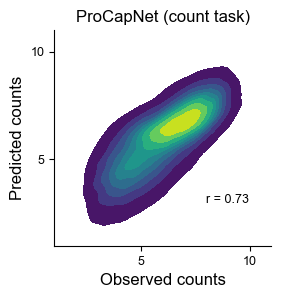

In [13]:
fig, ax = plt.subplots(figsize=(2.8,2.8))
g = sns.kdeplot(x=xs, y=ys, cmap="viridis", fill=True, ax=ax)
g.spines[["top", "right"]].set_visible(False)
g.text(x=8, y=3, s=f"r = {corr:.2f}", fontsize=sfontsize)
g.set_title("ProCapNet (count task)", fontsize=bfontsize)
g.set_xlabel("Observed counts", fontsize=bfontsize)
g.set_ylabel("Predicted counts", fontsize=bfontsize)
g.set_xlim([1,11])
g.set_ylim([1,11])
g.set_xticks([5,10])
g.set_yticks([5,10])
g.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig2b.pdf", bbox_inches="tight", transparent=True)

## Profile task

In [16]:
# Get observed profiles for biological replicates

obs_profs2 = {}
for rep in [f"{s}a", f"{s}b"]:
	obs_profs2[rep] = extract_observed_profiles(f"/home/kl945/EnhancerAtlas/PROcap/Alignments/{rep}_5pl.bw",
											f"/home/kl945/EnhancerAtlas/PROcap/Alignments/{rep}_5mn.bw",
											f"{PROJECT_DIR_o}procapnet/processed/{s}/peaks.bed.gz",
											out_window=1000)

== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks.bed.gz
Profile length: 1000
Num. Examples: 76899
== In Extract Profiles ==
Peak filepath: /home/yc2553/projects/HEA/output/procapnet/processed/SC5/peaks.bed.gz
Profile length: 1000
Num. Examples: 76899


In [17]:
# Get predicted profiles

pred_profs = {}
for k in timestamps:
	fold, timestamp = k.split(".")
	pred_profs[int(fold)] = np.load(f"{PROJECT_DIR_o}procapnet/model_out/{s}/{model_type}/{k}/test_pred_profiles.npy")

In [18]:
# Concatenate across folds

obs_profs_all = np.concatenate([obs_profs[fold] for fold in range(1,8)], axis=0)
pred_profs_all = np.concatenate([pred_profs[fold] for fold in range(1,8)], axis=0)

In [19]:
# Get averaged observed profiles

avg_obs_profs = np.tile(obs_profs_all.mean(axis=0, keepdims=True), (len(obs_profs_all),1,1))

In [20]:
def reshape(arr):
	arr = arr.reshape(arr.shape[0], -1)
	arr = np.expand_dims(arr, (1, 3))
	return arr

In [21]:
def get_jsd(arr1, arr2):
	arr1, arr2 = [reshape(arr) for arr in [arr1, arr2]]
	sum1, sum2 = [np.sum(arr, axis=(1,2,3)) for arr in [arr1, arr2]]
	mask = (sum1 != 0) & (sum2 != 0)
	arr1_filtered, arr2_filtered = [arr[mask] for arr in [arr1, arr2]]

	jsd = profile_jsd(arr1_filtered, arr2_filtered, 
						prof_smooth_kernel_sigma=7, prof_smooth_kernel_width=81,
						smooth_true_profs=False).flatten().tolist()
	return jsd

In [22]:
jsd = {"Biological replicates": get_jsd(obs_profs2[f"{s}a"], obs_profs2[f"{s}b"]),
	   "Predicted vs. Observed": get_jsd(pred_profs_all, obs_profs_all),
	   "Average observed\nvs. Observed": get_jsd(avg_obs_profs, obs_profs_all)
	  }

In [23]:
df_jsd = pd.DataFrame([{"group": k, "jsd": v}
				    for k, values in jsd.items()
				    for v in values
				])
df_jsd.head(2)

,group,jsd
0,Biological replicates,0.279709
1,Biological replicates,0.092792


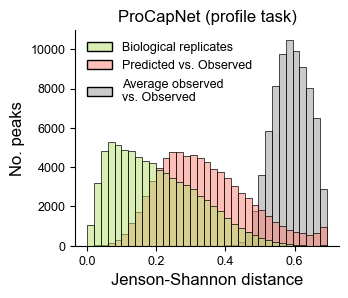

In [24]:
fig, ax = plt.subplots(figsize=(3.4, 2.8))
g = sns.histplot(data=df_jsd, x="jsd", hue="group", bins=35, alpha=0.5,
			palette=["#b3de69", "#fb8072", "#969696"], ax=ax
			)
g.spines[["top", "right"]].set_visible(False)
sns.move_legend(ax, loc="upper left", fontsize=sfontsize, frameon=False, title="")
g.set_title("ProCapNet (profile task)", fontsize=bfontsize)
g.set_xlabel("Jenson-Shannon distance", fontsize=bfontsize)
g.set_ylabel("No. peaks", fontsize=bfontsize)
g.tick_params(labelsize=sfontsize)
plt.savefig(f"{PROJECT_DIR_o}figures/ExtDataFig2c.pdf", bbox_inches="tight", transparent=True)

# Contribution scores

In [27]:
# Indiviual models
# Only do this for SC5

script = f"{PROJECT_DIR_s}slurm/deepshap.sh"
for k in timestamps:
	fold, timestamp = k.split(".")
	commands = " ".join(["sbatch " + script,
						s,
						model_type,
						f"{PROJECT_DIR_o}procapnet/",
						fold,
						timestamp
						])
	print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 1 2025-03-14_23-40-51
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 2 2025-03-14_23-40-51
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 3 2025-03-13_13-25-41
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 4 2025-03-13_13-25-54
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 5 2025-03-13_13-26-23
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap.

In [30]:
# Merge deepshap files: average values

script = f"{PROJECT_DIR_s}slurm/deepshap_ensembl.sh"
commands = " ".join(["sbatch " + script,
					s,
					model_type,
					f"{PROJECT_DIR_o}procapnet/",
					",".join(timestamps),
					])
print(commands)

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/deepshap_ensembl.sh SC5 strand_merged_umap /home/yc2553/projects/HEA/output/procapnet/ 1.2025-03-14_23-40-51,2.2025-03-14_23-40-51,3.2025-03-13_13-25-41,4.2025-03-13_13-25-54,5.2025-03-13_13-26-23,6.2025-03-13_13-26-29,7.2025-03-13_13-26-44


# TF-Modisco

In [29]:
tasks = ["counts", "profile"]

In [32]:
script = f"{PROJECT_DIR_s}slurm/modisco.sh"
for task in tasks:
	# Remember to remove the old file; otherwise it's not able to rewrite them
	# outputfile = f"{PROJECT_DIR_o}procapnet/modisco_out/{s}/{model_type}/merged/{s}_{task}_modisco_results.hd5"
	# if exists(outputfile):
	# 	subprocess.run("rm " + outputfile, shell=True)
	commands = ["sbatch", script,
				s,
				model_type,
				task,
				f"{PROJECT_DIR_o}procapnet/"
				]
	print(" ".join(commands))

sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/modisco.sh SC5 strand_merged_umap counts /home/yc2553/projects/HEA/output/procapnet/
sbatch /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/procapnet/slurm/modisco.sh SC5 strand_merged_umap profile /home/yc2553/projects/HEA/output/procapnet/


In [35]:
# This command will take the results from the tfmodisco-lite run, as well as a reference database of motifs to compare the extracted patterns to, and generate a HTML report. Each pattern that is extracted by tfmodisco-lite is compared against the database of motifs using TOMTOM to match them with prior knowledge.

motif_file = f"{PROJECT_DIR_r}other/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt"
for task in tasks:
	inputfile = f"{PROJECT_DIR_o}procapnet/modisco_out/{s}/strand_merged_umap/merged/{task}_modisco_results.hd5"
	outdir = f"{PROJECT_DIR_o}procapnet/modisco_out/{s}/strand_merged_umap/merged/{task}/"
	if not exists(outdir):
		os.mkdir(outdir)
	commands = ["modisco report",
				"-i", inputfile,
				"-o", outdir,
				"-s", outdir,
				"-m", motif_file
				]
	print(" ".join(commands))

modisco report -i /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/counts_modisco_results.hd5 -o /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/counts/ -s /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/counts/ -m /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/other/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
modisco report -i /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/profile_modisco_results.hd5 -o /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/profile/ -s /home/yc2553/projects/HEA/output/procapnet/modisco_out/SC5/strand_merged_umap/merged/profile/ -m /fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/other/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt
